# Molecule Property Prediction using a Graph Convolutional Neural Network

In [4]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from IPython.display import HTML
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
from torch_geometric import transforms
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from IPython.display import HTML

## Dataset

In [2]:
class SetTarget:
    """
    This transform modifies the labels vector per data sample to only keep 
    the label for a specific target (there are 19 targets in QM9).
    """

    def __call__(self, data):
        # Hard coding the target to be dipole moment
        target = 0
        data.y = data.y[:, target]
        return data


class CompleteGraph:
    """
    This transform adds all pairwise edges into the edge index per data sample, 
    then removes self loops, i.e. it builds a fully connected or complete graph
    """

    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

In [5]:
transform = transforms.Compose([CompleteGraph(), SetTarget()])

In [6]:
dataset = QM9(root='data/QM9', transform=transform)

In [7]:
allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H",
    "Unknown",
]


def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]


def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])

        if data.edge_attr[i].sum() == 0:
            continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D

    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style: {}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer


def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

In [9]:
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]

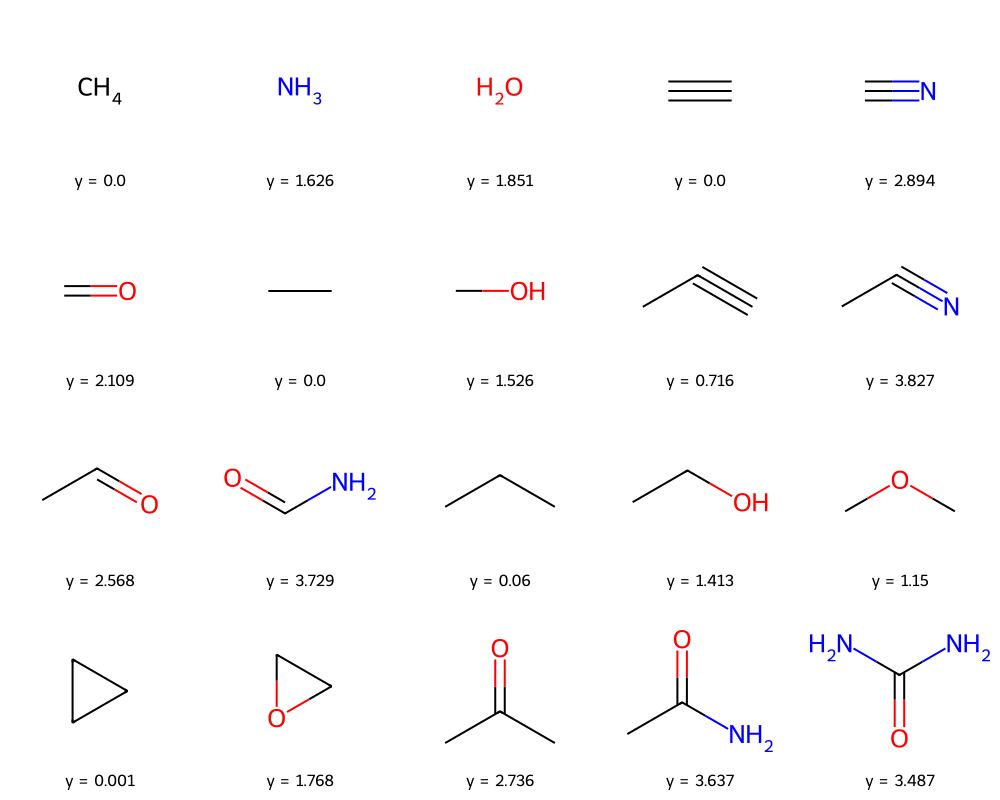

In [11]:
num_viz = 20
mols = [to_rdkit(train_dataset[i]) for i in range(num_viz)]
values = [str(round(float(train_dataset[i].y), 3)) for i in range(num_viz)]

Chem.Draw.MolsToGridImage(mols, legends=[f"y = {value}" for value in values], molsPerRow=5)

In [12]:
example_data = train_dataset[123]

In [13]:
example_data

Data(x=[10, 11], edge_index=[2, 90], edge_attr=[90, 4], y=[1], pos=[10, 3], idx=[1], name='gdb_127', z=[10])

In [14]:
example_data.x

tensor([[0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])